In [1]:
import torch
from torch.distributions.gamma import Gamma

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

# !pip install neuroCombat
from neuroCombat import neuroCombat as combat

### Data Generation

Fix $p$ to be dimension of data, i.e. $\mathcal{X} = \mathbb{R}^p$, $m$ is the number of domains, and `num_features` is the number of different sample conditions for the design matrix

Assuming that 
$$ y_{ijk} = \alpha_k + \mathbf{X}_{ij} \beta_{k} + \gamma_{ik} + \delta_{ik}\varepsilon_{ijk} $$

we fix $\alpha, \beta$ randomly, and fix $\gamma, \tau, \lambda, \theta, \sigma$ such that

$$\gamma_{ik}\sim \mathcal{N}(\gamma_i, \tau^2_i)$$
$$\delta_{ik}\sim \operatorname{InverseGamma}(\lambda_i, \theta_i)$$
$$\varepsilon_{ijk}\sim \mathcal{N}(0, \sigma^2_k)$$

In [13]:
def generate_parameters(dim=10, num_domains=2, num_features=1, seed=None):
    if seed:
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)

    p = dim # Dimension of vector (i.e. each sample)
    m = num_domains # Number of domains


    # Currently sampling using transformation of rand which is uniform U[0,1], but these can be changed
    alpha = torch.rand(p) * 10
    sigma = torch.rand(p) * 5

    beta = torch.rand(p,num_features) * 3

    gamma = torch.rand(m) * 3
    tau = torch.rand(m) * 5

    lambda_ = torch.rand(m) * 10
    theta = torch.rand(m) * 10
    
    
    # Generate gamma_iks and delta_iks using fixed gamma, tau, lambda, theta
    gammas = []
    deltas = []

    for i in range(m):
        gammas.append(tau[i]*torch.randn(p)+gamma[i])

        gamma_dist = Gamma(lambda_[i], 1/theta[i])
        deltas.append(gamma_dist.sample((p,)).pow(-1).pow(1/2))


    # We need to constrain the gammas to sum to 0, so we don't use the last set and append the negative sum
    gammas = torch.vstack(gammas[:-1])
    deltas = torch.vstack(deltas)

    gammas = torch.vstack((gammas, -gammas.sum(axis=0)))
    
    return {
        "dim": dim,
        "num_domains": num_domains,
        "alpha": alpha,
        "sigma": sigma,
        "beta": beta,
        "gamma": gamma,
        "tau": tau,
        "lambda": lambda_,
        "theta": theta,
        "gammas": gammas,
        "deltas": deltas
    }

In [3]:
# Need to manually specify design matrices of sample conditions, each matrix in design_matrices needs 
# to be of num_features length (the value you used to generate the parameters above). 

design_matrices = torch.tensor([[0], [1]], dtype=torch.float)

def generate_data(parameters, design_matrices, num_samples):
    domain = []
    design_mats = []
    observed_data = []

    for i in range(parameters["num_domains"]):    
        for mat in design_matrices:
            for j in range(num_samples):
                yij = parameters["alpha"] + parameters["beta"] @ mat + parameters["gammas"][i] + torch.mul(parameters["deltas"][i], torch.mul(torch.randn(parameters["dim"]), parameters["sigma"]))
                domain.append(i)
                design_mats.append(mat.numpy())
                observed_data.append(yij.numpy())
                
    data = np.array(observed_data)
    domain = np.array(domain)
    sample_conds = np.array(design_mats)   
    
    return data, domain, sample_conds

### Perform Combat and Measure Error

In [4]:
def perform_combat(data, domain, sample_conds):
    covars = pd.DataFrame({"domain": domain, **{f"X{i+1}": sample_conds[:, i] for i in range(sample_conds.shape[1])}})
    output = combat(dat = data.T, covars=covars, batch_col="domain", categorical_cols=["X1"], parametric=True)

    return output["estimates"], output["data"]


def compute_error(estimates, parameters):
    dgamma_star = estimates["gamma.star"][1] - estimates["gamma.star"][0]
    dgamma = (parameters["gammas"][1] - parameters["gammas"][0]).numpy()
    rmse_gamma = np.sqrt(np.mean(np.square(dgamma_star-dgamma)))

    ddelta_star = estimates['delta.star'][1] - estimates['delta.star'][0]
    ddelta = (parameters["deltas"][1] - parameters["deltas"][0]).numpy()
    rmse_delta = np.sqrt(np.mean(np.square(ddelta_star-ddelta)))

    return rmse_delta, rmse_gamma

### Run Simulations

In [15]:
num_simulations = 10

gamma_iters = []
delta_iters = []

for i in range(num_simulations):

    delta_err = {}
    gamma_err = {}

    for num_samples in range(50, 2500, 50):

        parameters = generate_parameters()
        data, domain, sample_conds = generate_data(parameters, design_matrices, num_samples=num_samples)

        estimates, _ = perform_combat(data, domain, sample_conds)

        rmse_delta, rmse_gamma = compute_error(estimates, parameters)

        delta_err[num_samples] = rmse_delta
        gamma_err[num_samples] = rmse_gamma

    delta_iters.append(delta_err)
    gamma_iters.append(gamma_err)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S mode

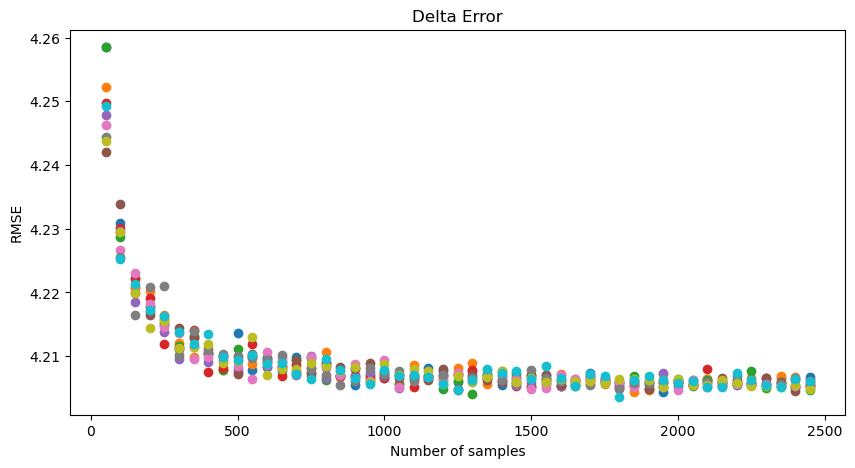

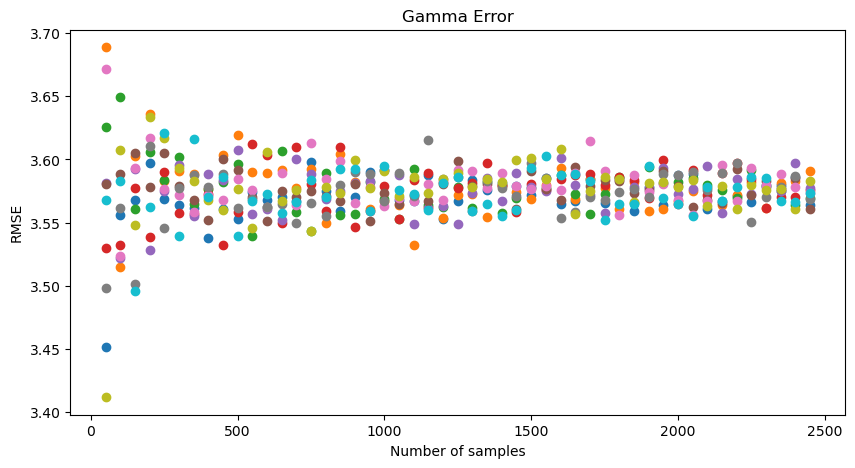

In [16]:
def plot_error(iters, title):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel("Number of samples")
    plt.ylabel("RMSE")
    
    for err in iters:
        plt.scatter(err.keys(), err.values())
    plt.show()

plot_error(delta_iters, "Delta Error")
plot_error(gamma_iters, "Gamma Error")

### Save and Load Parameters/Data

In [11]:
def save_params(parameters, filename):
    torch.save(parameters, filename)

def load_params(filename):
    return torch.load(filename)

def save_results(results, filename):
    torch.save(results, filename)

def load_results(filename):
    return torch.load(filename)

save_params(parameters, "parameters.pt")
save_results(delta_iters, "delta_iters.pt")
save_results(gamma_iters, "gamma_iters.pt")

### Plot Harmonized Data

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


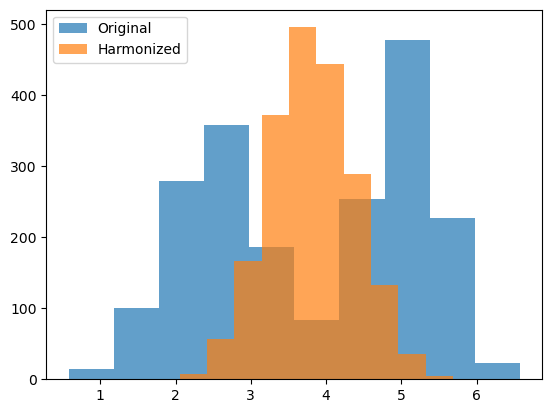

In [18]:
parameters = generate_parameters()
data, domain, sample_conds = generate_data(parameters, design_matrices, num_samples=1000)
estimates, combat_data = perform_combat(data, domain, sample_conds)

pos = 0
dom = 0
cond = 0

def plot(pos = 0, dom=0, cond=0):
    idx = (sample_conds == cond).squeeze()
    orig_data = data[idx, pos]
    harmonized_data = combat_data.T[idx, pos]

    plt.hist(orig_data, alpha=0.7, label="Original")
    plt.hist(harmonized_data, alpha=0.7, label="Harmonized")
    plt.legend()

    plt.show()
    
plot(pos = 9, dom = 1, cond = 0)